In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

1. LOAD + PREPROCESS DATA

In [12]:
# Load dataset
data = fetch_california_housing()
X = data.data
y = data.target

In [13]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
# 5-fold cross validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

Compute RMSE using CV for a given set of XGBoost params

In [15]:
def compute_cv_rmse(params):
    model = xgb.XGBRegressor(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        random_state=42,
        n_jobs=1
    )

    fold_rmse = []

    for train_idx, val_idx in kf.split(X):
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict(X[val_idx])
        rmse = np.sqrt(mean_squared_error(y[val_idx], preds))
        fold_rmse.append(rmse)

    return np.mean(fold_rmse)

2. BAYESIAN OPTIMIZATION

In [16]:
# Define search space
space = [
    Integer(50, 400, name='n_estimators'),
    Integer(2, 10, name='max_depth'),
    Real(0.01, 0.3, name='learning_rate'),
    Real(0.5, 1.0, name='subsample'),
    Real(0.5, 1.0, name='colsample_bytree')
]

@use_named_args(space)
def bayes_objective(**params):
    p = [
        params["n_estimators"],
        params["max_depth"],
        params["learning_rate"],
        params["subsample"],
        params["colsample_bytree"]
    ]
    return compute_cv_rmse(p)


print("\nRunning Bayesian Optimization...")
bayes_result = gp_minimize(
    func=bayes_objective,
    dimensions=space,
    n_calls=20,
    random_state=42
)

print("\nBest Bayesian RMSE:", bayes_result.fun)
print("Best Bayesian Params:", bayes_result.x)


Running Bayesian Optimization...

Best Bayesian RMSE: 0.4504094307617322
Best Bayesian Params: [np.int64(350), np.int64(7), 0.10908110697160128, 0.9133556547064184, 0.7415124852964221]


3. RANDOM SEARCH (Same Budget)

In [17]:
print("\nRunning Random Search...")

def random_sample_params():
    return [
        np.random.randint(50, 401),   # n_estimators
        np.random.randint(2, 11),     # max_depth
        np.random.uniform(0.01, 0.3), # learning_rate
        np.random.uniform(0.5, 1.0),  # subsample
        np.random.uniform(0.5, 1.0)   # colsample_bytree
    ]

random_scores = []
random_params = []

for i in range(20):  # match BO calls
    p = random_sample_params()
    score = compute_cv_rmse(p)
    random_scores.append(score)
    random_params.append(p)

best_random_rmse = min(random_scores)
best_random_param = random_params[np.argmin(random_scores)]

print("\nBest Random Search RMSE:", best_random_rmse)
print("Best Random Search Params:", best_random_param)


Running Random Search...

Best Random Search RMSE: 0.46034624137635677
Best Random Search Params: [166, 6, 0.14348997896553806, 0.7888012080456513, 0.6251810526330602]


 4. COMPARISON PLOT

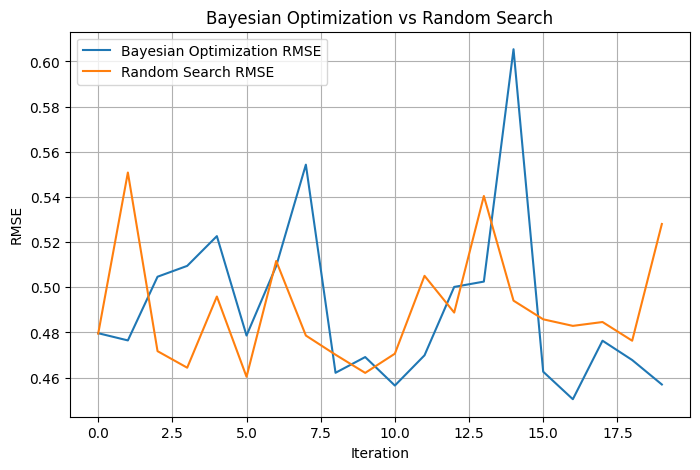

In [18]:
plt.figure(figsize=(8,5))
plt.plot(bayes_result.func_vals, label="Bayesian Optimization RMSE")
plt.plot(random_scores, label="Random Search RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Bayesian Optimization vs Random Search")
plt.legend()
plt.grid(True)
plt.show()